In [1]:
# type: ignore

import typing
from pathlib import Path

import librosa
from datasets import load_dataset, Audio
import gigaam
from gigaam.model import GigaAMASR
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from asr_eval.datasets.recording import Recording
from asr_eval.align.data import MatchesList
from asr_eval.align.timings import fill_word_timings_inplace, CannotFillTimings
from asr_eval.align.parsing import parse_multivariant_string, colorize_parsed_string
from asr_eval.align.plots import draw_timed_transcription
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.evaluation import default_evaluation_pipeline
from asr_eval.streaming.model import TranscriptionChunk
from asr_eval.streaming.evaluation import RecordingStreamingEvaluation
from asr_eval.align.recursive import align
from asr_eval.streaming.plots import (
    partial_alignments_plot,
    visualize_history,
    streaming_error_vs_latency_histogram,
    latency_plot,
    show_last_alignments,
)

In [2]:
text = (
    '(7-8 мая) в Пуэрто-Рико прошёл {шестнадцатый|16-й|16}'
    ' этап "Формулы-1" с фондом 100,000$!'
)

for method in 'space', 'razdel', 'wordpunct_tokenize', 'asr_eval':
    tokens = parse_multivariant_string(text, method=method)
    colored_str, colors = colorize_parsed_string(text, tokens)
    print(f'{method: <20}', colored_str)

space                (7-8 мая) в Пуэрто-Рико прошёл {шестнадцатый|16-й|16} этап "Формулы-1" с фондом 100,000$!
razdel               (7-8 мая) в Пуэрто-Рико прошёл {шестнадцатый|16-й|16} этап "Формулы-1" с фондом 100,000$!
wordpunct_tokenize   (7-8 мая) в Пуэрто-Рико прошёл {шестнадцатый|16-й|16} этап "Формулы-1" с фондом 100,000$!
asr_eval             (7-8 мая) в Пуэрто-Рико прошёл {шестнадцатый|16-й|16} этап "Формулы-1" с фондом 100,000$!


In [2]:
# type: ignore

waveform: npt.NDArray[np.floating] = (
    librosa.load('tests/testdata/formula1.mp3', sr=16000)[0])
waveform += waveform[::-1] / 4  # add some speech-like noise

text = Path('tests/testdata/formula1.txt').read_text()
tokens = parse_multivariant_string(text)

model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))
fill_word_timings_inplace(model, waveform, tokens, verbose=True)

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

Propagated timings from [седьмого (0.5-1.0)] to [7 (0.5-1.0)]
Propagated timings from [восьмого (1.2-1.7)] to [8 (1.2-1.7)]
Propagated timings from [шестнадцатый (4.9-5.8)] to [16й (4.9-5.8)]
Propagated timings from [шестнадцатый (4.9-5.8)] to [16 (4.9-5.8)]
Propagated timings from [шестнадцатый (4.9-5.8)] to [16 (4.9-5.4), й (5.4-5.8)]
Propagated timings from [формулы (6.6-7.1), один (7.3-7.7)] to [формулы (6.6-7.1), 1 (7.3-7.7)]
Propagated timings from [сто (9.0-9.3), тысяч (9.5-9.8), долларов (10.0-10.5)] to [100 (9.0-9.3), тысяч (9.5-9.8), долларов (10.0-10.5)]
Propagated timings from [100 (9.0-9.3), тысяч (9.5-9.8), долларов (10.0-10.5)] to [100 (9.0-9.3), тыщ (9.5-9.8), долларов (10.0-10.5)]
Propagated timings from [100 (9.0-9.3), тысяч (9.5-9.8), долларов (10.0-10.5)] to [100 (9.0-9.3), 000 (9.5-9.8), долларов (10.0-10.5)]
Propagated timings from [100 (9.0-9.3), тысяч (9.5-9.8), долларов (10.0-10.5)] to [100 (9.0-9.3), тысяч (9.5-9.8), $ (10.0-10.5)]
Propagated timings from [сто

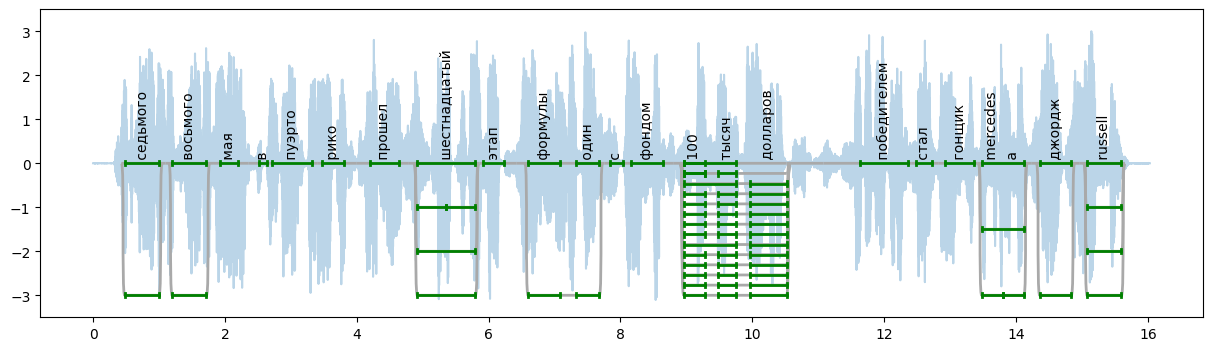

{седьмого|7} - {восьмого|8} мая в Пуэрто-Рико прошёл {шестнадцатый|16-й|16й|16} этап {"Формулы-1"|"Формулы один"} с фондом {$100000|$100,000|100000$|100,000$|сто тысяч $|сто тыщ $|100 тысяч $|100 тыщ $|100000 долларов|100,000 долларов|сто тысяч долларов|сто тыщ долларов|100 тысяч долларов|100 тыщ долларов} ! Победителем стал гонщик {«Мерседеса»|Mercedes|Mercedes-а} {George|Джордж} {Расселл|Рассел|Russell|Russel} .


In [4]:
 # type: ignore

plt.figure(figsize=(15, 4))
plt.plot(np.arange(len(waveform)) / 16000,
    3 * waveform / waveform.max(), alpha=0.3, zorder=-1)
draw_timed_transcription(tokens, y_delta=-3)
plt.ylim(-3.5, 3.5)
plt.show()

print(colorize_parsed_string(text, tokens)[0])

In [ ]:
asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=0.5)
asr.start_thread()

recording = Recording(
    transcription=text,
    transcription_words=tokens,
    waveform=waveform,
)
eval = default_evaluation_pipeline(recording, asr)

asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

In [7]:
print(TranscriptionChunk.join(eval.output_chunks))
print(eval.partial_alignments[-1].pred)

седьмого восьмого мая эру дарика прошёл шестнадцатый этаж формулы один с фондом сто тысяч долларов победителем стал гонщик мерседеса
[Token(седьмого), Token(восьмого), Token(мая), Token(эру), Token(дарика), Token(прошел), Token(шестнадцатый), Token(этаж), Token(формулы), Token(один), Token(с), Token(фондом), Token(сто), Token(тысяч), Token(долларов), Token(победителем), Token(стал), Token(гонщик), Token(мерседеса)]


In [8]:
eval.partial_alignments[-1].alignment.matches

[Match(Token(седьмого, t=(0.5, 1.0)), Token(седьмого)),
 Match(Token(восьмого, t=(1.2, 1.7)), Token(восьмого)),
 Match(Token(мая, t=(1.9, 2.2)), Token(мая)),
 Match(Token(в, t=(2.5, 2.6)), ),
 Match(Token(пуэрто, t=(2.7, 3.3)), Token(эру)),
 Match(Token(рико, t=(3.5, 3.8)), Token(дарика)),
 Match(Token(прошел, t=(4.2, 4.6)), Token(прошел)),
 Match(Token(шестнадцатый, t=(4.9, 5.8)), Token(шестнадцатый)),
 Match(Token(этап, t=(5.9, 6.2)), Token(этаж)),
 Match(Token(формулы, t=(6.6, 7.1)), Token(формулы)),
 Match(Token(один, t=(7.3, 7.7)), Token(один)),
 Match(Token(с, t=(7.8, 8.0)), Token(с)),
 Match(Token(фондом, t=(8.2, 8.6)), Token(фондом)),
 Match(Token(сто, t=(9.0, 9.3)), Token(сто)),
 Match(Token(тысяч, t=(9.5, 9.8)), Token(тысяч)),
 Match(Token(долларов, t=(10.0, 10.5)), Token(долларов)),
 Match(Token(победителем, t=(11.6, 12.4)), Token(победителем)),
 Match(Token(стал, t=(12.5, 12.7)), Token(стал)),
 Match(Token(гонщик, t=(12.9, 13.4)), Token(гонщик)),
 Match(Token(мерседеса, t=(

In [9]:
eval.partial_alignments[-1].get_error_positions()

[StreamingASRErrorPosition(start_time=0.48, end_time=1.0, processed_time=16.031375, status='correct'),
 StreamingASRErrorPosition(start_time=1.2, end_time=1.72, processed_time=16.031375, status='correct'),
 StreamingASRErrorPosition(start_time=1.92, end_time=2.2, processed_time=16.031375, status='correct'),
 StreamingASRErrorPosition(start_time=2.52, end_time=2.64, processed_time=16.031375, status='deletion'),
 StreamingASRErrorPosition(start_time=2.72, end_time=3.32, processed_time=16.031375, status='replacement'),
 StreamingASRErrorPosition(start_time=3.48, end_time=3.8, processed_time=16.031375, status='replacement'),
 StreamingASRErrorPosition(start_time=4.2, end_time=4.64, processed_time=16.031375, status='correct'),
 StreamingASRErrorPosition(start_time=4.92, end_time=5.8, processed_time=16.031375, status='correct'),
 StreamingASRErrorPosition(start_time=5.92, end_time=6.24, processed_time=16.031375, status='replacement'),
 StreamingASRErrorPosition(start_time=6.6, end_time=7.08,

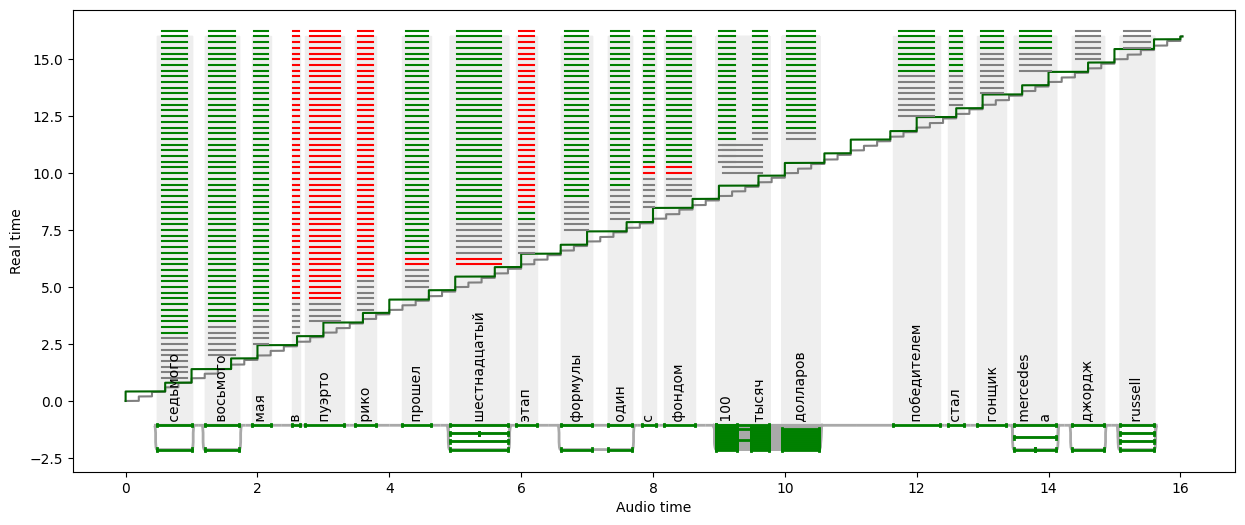

In [10]:
# type: ignore

plt.figure(figsize=(15, 6))
partial_alignments_plot(eval)
plt.show()

In [3]:
# type: ignore

dataset = (
    load_dataset('bond005/podlodka_speech')['test']
    .cast_column('audio', Audio(sampling_rate=16_000))
)

gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))
asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=0.5)
asr.start_thread()

evals: list[RecordingStreamingEvaluation] = []
for sample in dataset:
    try:
        recording = Recording.from_sample(sample, use_gigaam=gigaam_model)
    except CannotFillTimings:
        continue
    evals.append(default_evaluation_pipeline(
        recording, asr, partial_alignment_interval=0.5
    ))

asr.stop_thread()

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

Transcribing 4c78a1a5-c2fc-4ff4-ba84-1d9e11a3deb5
Transcribed 4c78a1a5-c2fc-4ff4-ba84-1d9e11a3deb5: и поэтому использовать их в повседневности не получается мы вынуждены отступать
Transcribing 22c71e00-27aa-455d-a3a7-7c3b5d56ee2e
Transcribed 22c71e00-27aa-455d-a3a7-7c3b5d56ee2e: да это отсутствие долго живущие бранчей другими словами отсутствие какому- [...]
Transcribing 276a719e-be4c-4eec-83dc-6dad08ef75bb
Transcribed 276a719e-be4c-4eec-83dc-6dad08ef75bb: то есть мы в каждый момент времени знаем про звук ещё и какое-то такое [...]
Transcribing 8428283b-50ef-41b4-ad48-b9d5d46f3673
Transcribed 8428283b-50ef-41b4-ad48-b9d5d46f3673: и мне кажется абсолютно все замечали что детские крики раздражают там и ты [...]
Transcribing c5065738-0ae5-4283-ba82-4312d9c6daa3
Transcribed c5065738-0ae5-4283-ba82-4312d9c6daa3: неужто не может быть какое-то количество дискретных столбиков где каждый [...]
Transcribing 38ab2ada-ec60-442e-bd27-8d093a8b33cc
Transcribed 38ab2ada-ec60-442e-bd27-8d093a8b33cc: вт

In [4]:
for i, eval in enumerate(evals):
    alignment: MatchesList = eval.partial_alignments[-1].alignment
    print(
        f'sample {i},', f'total_true_len={alignment.total_true_len},', alignment.score
    )

sample 0, total_true_len=13, AlignmentScore(n_word_errors=3, n_correct=10, n_char_errors=20)
sample 1, total_true_len=49, AlignmentScore(n_word_errors=14, n_correct=35, n_char_errors=25)
sample 2, total_true_len=68, AlignmentScore(n_word_errors=11, n_correct=58, n_char_errors=35)
sample 3, total_true_len=45, AlignmentScore(n_word_errors=6, n_correct=39, n_char_errors=33)
sample 4, total_true_len=34, AlignmentScore(n_word_errors=14, n_correct=20, n_char_errors=44)
sample 5, total_true_len=81, AlignmentScore(n_word_errors=18, n_correct=63, n_char_errors=64)
sample 6, total_true_len=52, AlignmentScore(n_word_errors=8, n_correct=45, n_char_errors=26)
sample 7, total_true_len=52, AlignmentScore(n_word_errors=17, n_correct=38, n_char_errors=86)
sample 8, total_true_len=53, AlignmentScore(n_word_errors=16, n_correct=39, n_char_errors=44)
sample 9, total_true_len=57, AlignmentScore(n_word_errors=17, n_correct=40, n_char_errors=41)
sample 10, total_true_len=77, AlignmentScore(n_word_errors=16, 

In [5]:
alignment.score.n_word_errors / max(1, alignment.total_true_len)

0.25806451612903225

In [6]:
# type: ignore

matches_list = align(
    parse_multivariant_string('nothing'),
    parse_multivariant_string('no thing'),
)
print(matches_list.matches)
print(matches_list.score)

[Match(, Token(no)), Match(Token(nothing), Token(thing))]
AlignmentScore(n_word_errors=2, n_correct=0, n_char_errors=4)


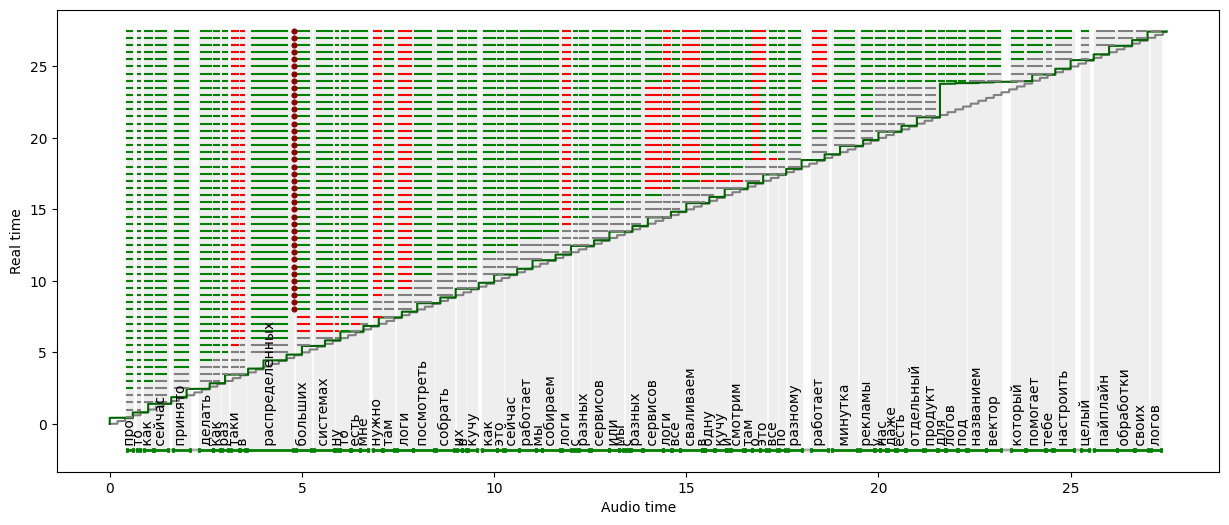

In [7]:
# type: ignore

plt.figure(figsize=(15, 6))
partial_alignments_plot(evals[10])
plt.show()

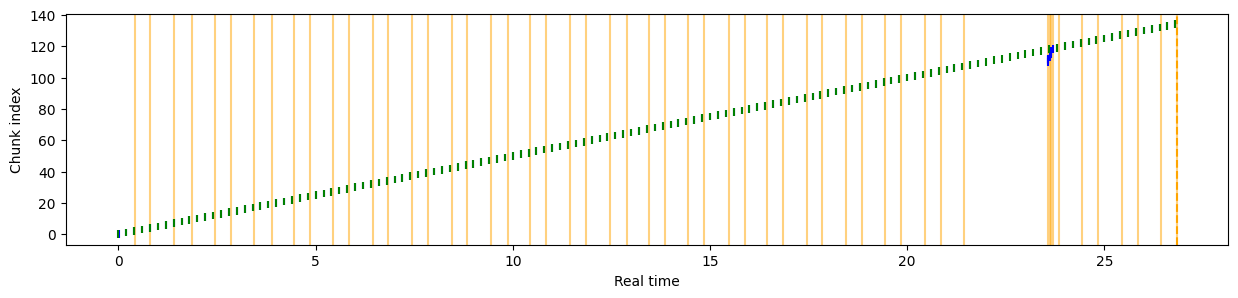

In [8]:
# type: ignore

plt.figure(figsize=(15, 3))
visualize_history(eval.input_chunks, eval.output_chunks)
plt.show()

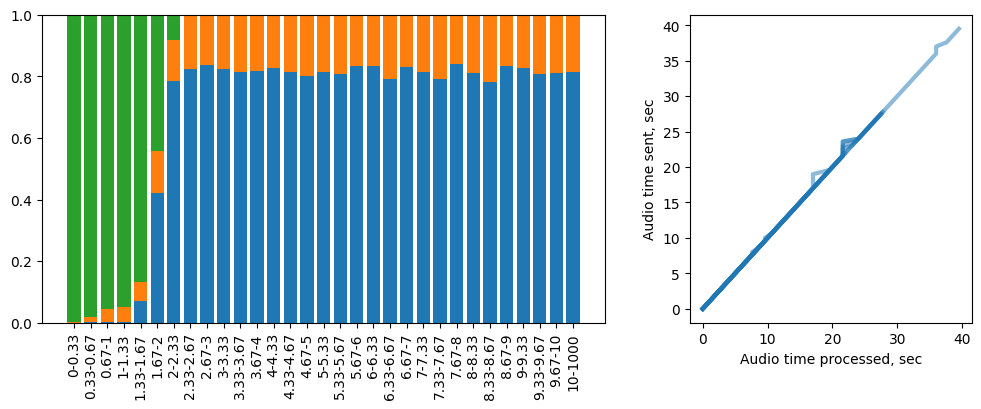

In [ ]:
# type: ignore

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, width_ratios=[2, 1])
streaming_error_vs_latency_histogram(evals, ax=ax1)
latency_plot(evals, ax=ax2)
plt.show()

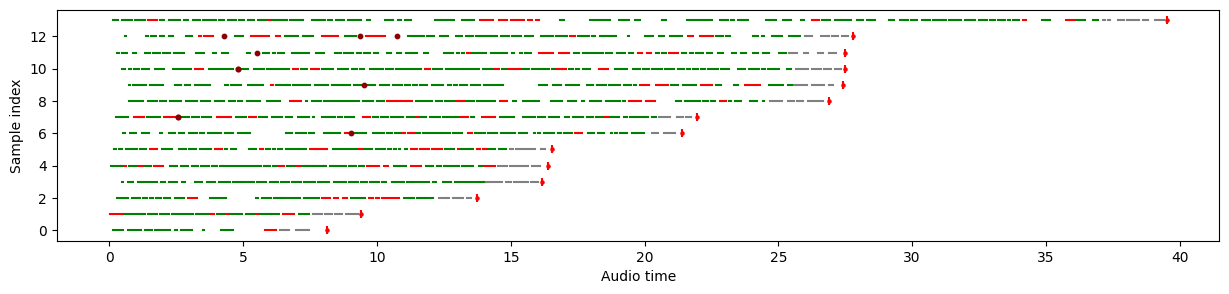

In [ ]:
# type: ignore

plt.figure(figsize=(15, 3))
show_last_alignments(evals)
plt.show()